# Import modules

In [1]:
import datetime
import itertools
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from tx_fast_hydrology.muskingum import Muskingum, ModelCollection, Connection
from tx_fast_hydrology.simulation import AsyncSimulation
from tx_fast_hydrology.da import KalmanFilter

# Load model collection

In [2]:
# Define model file input path
input_path = '../data/travis-county-lo-res-model-partitioned.json'
# Load model collection from file
model_collection = ModelCollection.from_file(input_path)

# Create model inputs

### Load NWM forcings

In [3]:
# Define path for NWM forcings
forcing_path = '../data/20220822_event'
# Required NWM variables
nwm_vars = ['qBucket', 'qSfcLatRunoff', 'streamflow']
# Date range to load
date_list = pd.date_range('20220822', '20220824', freq='h', tz='utc')[:-1]

# Loop through HDF5 files and load forcings into memory
streamflows = []
runoffs = []
buckets = []
for date in date_list:
    date_str = date.strftime('%Y%m%d%H')
    streamflow = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='no_data_assimilation__streamflow')
    runoff = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='no_data_assimilation__qSfcLatRunoff')
    bucket = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='no_data_assimilation__qBucket')
    streamflows.append(streamflow)
    runoffs.append(runoff)
    buckets.append(bucket)
# Concatenate all forcings into single dataframe
streamflow = pd.concat(streamflows)
runoff = pd.concat(runoffs)
bucket = pd.concat(buckets)
# Lateral inflow at each reach is equal to runoff plus bucket recharge
forcing = runoff + bucket

# Ensure no duplicate entries
forcing = forcing.groupby(level=0).mean()
streamflow = streamflow.groupby(level=0).mean()

# Format column types
forcing.columns = forcing.columns.astype(str)
streamflow.columns = forcing.columns.astype(str)

### Create inputs to model based on forcings

In [4]:
# Create input table with lateral overflow into each modeled reach
input_columns = list(itertools.chain.from_iterable([model.reach_ids for model 
                                                    in model_collection.models.values()]))
input_index = forcing.index.copy()
inputs = pd.DataFrame(0., index=input_index, columns=input_columns)

# Fill input table with forcings for each reach
for col in inputs.columns:
    if col in forcing.columns:
        inputs[col] = forcing[col]

# Add inflow to upstream boundary reaches
upstream_inputs = {
    '5779305' : '5781161',
    '5785187' : '5785899',
    '5786029' : '5785351'
}
for downstream_reach, upstream_reach in upstream_inputs.items():
    inputs[downstream_reach] += streamflow[upstream_reach]

In [5]:
# Resample forcing input table to frequency of model timestep
dt = model_collection.timedelta.seconds
inputs = inputs.resample(f'{dt}s').mean()
inputs = inputs.interpolate().bfill().ffill()
assert not inputs.isnull().any().any()

# Gather gage measurements for event period

In [6]:
# Load table of mappings from USGS Gage IDs to NWM COMIDs
usgs_to_comid = pd.read_csv('../data/usgs_to_comid.csv', index_col=0)
usgs_to_comid['gage_id'] = usgs_to_comid['gage_id'].astype(str)
usgs_to_comid['comid'] = usgs_to_comid['comid'].astype(str)
# Filter 
usgs_to_comid = usgs_to_comid[usgs_to_comid['comid'].isin(input_columns)]
usgs_to_comid = pd.Series(usgs_to_comid['comid'].values, index=usgs_to_comid['gage_id'].values)

# Load table of USGS gage measurements
measurements = pd.read_hdf('../data/gages.h5', key='usgs')
measurements.columns = measurements.columns.astype(int).astype(str)
# Filter measurements to those with associated COMIDs
measurements = measurements[usgs_to_comid.index]
measurements.columns = measurements.columns.map(usgs_to_comid)
measurements = measurements.loc[forcing.index[0]:forcing.index[-1]]
measurements = measurements.dropna(axis=1)
measurements = measurements.loc[:, ~(measurements == 0.).all(axis=0).values]
measurements = measurements.loc[:, ~measurements.columns.duplicated()].copy()
measurements = measurements.resample(f'{dt}s').mean().interpolate().ffill().bfill()

# Set up Kalman Filter

In [7]:
# Set up Kalman Filtering
for model in model_collection.models.values():
    # Find subset of gages for each sub-model
    model_sites = [reach_id for reach_id in model.reach_ids 
                    if reach_id in measurements.columns]
    if model_sites:
        # Get subset of measurements for sub-model
        basin_measurements = measurements[model_sites]
        # Process noise covariance matrix
        Q_cov = 1. * np.eye(model.n)
        # Measurement noise covariance matrix
        R_cov = 1. * np.eye(basin_measurements.shape[1])
        # Initial estimate of error covariance matrix
        P_t_init = Q_cov.copy()
        # Create Kalman Filter
        kf = KalmanFilter(model, basin_measurements, Q_cov, R_cov, P_t_init)
        # Bind Kalman Filter to model
        model.bind_callback(kf, key='kf')

# Prepare and simulate model

### Prepare model for simulation

In [8]:
# Add downstream boundaries to model
for model in model_collection.models.values():
    outlet = model.startnodes[model.startnodes == model.endnodes].item()
    model.set_transmissive_boundary(outlet)

# Set starting time of each model to just before start of forcings
timedelta = pd.to_timedelta(dt, unit='s')
for model_name, model in model_collection.models.items():
    model.datetime = inputs.index[0] - timedelta

# Set up simulation
simulation = AsyncSimulation(model_collection, inputs)

### Simulate model

In [9]:
# Simulate models
outputs_da = await simulation.simulate()
# Collect outputs into a single table
outputs_da = pd.concat([series for series in outputs_da.values()], axis=1)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# Plot results

Text(0.5, 1.0, 'Travis County Model: Discharge response to storm event on 8/22/22')

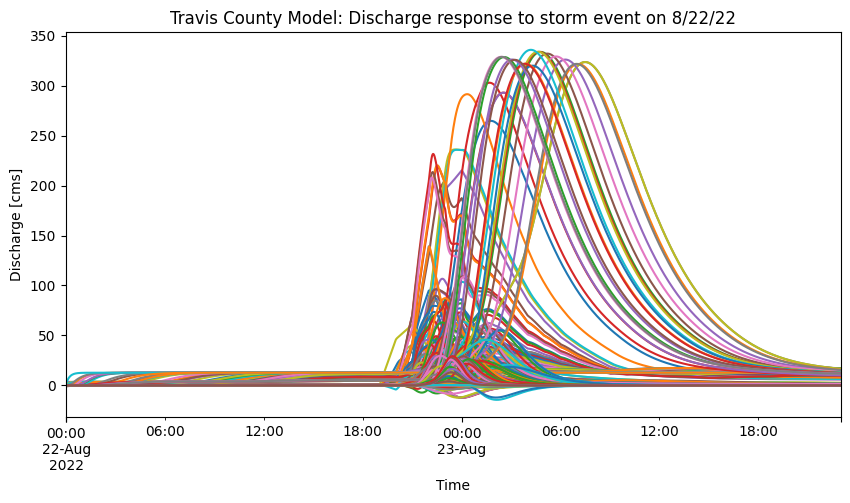

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))

outputs_da.plot(ax=ax, legend=False)
plt.xlabel('Time')
plt.ylabel('Discharge [cms]')
plt.title('Travis County Model: Discharge response to storm event on 8/22/22')

# Compare results

### Run model without DA

In [11]:
# Define model file input path
input_path = '../data/travis-county-lo-res-model-partitioned.json'
# Load model collection from file
model_collection = ModelCollection.from_file(input_path)

# Add downstream boundaries to model
for model in model_collection.models.values():
    outlet = model.startnodes[model.startnodes == model.endnodes].item()
    model.set_transmissive_boundary(outlet)

# Set starting time of each model to just before start of forcings
timedelta = pd.to_timedelta(dt, unit='s')
for model_name, model in model_collection.models.items():
    model.datetime = inputs.index[0] - timedelta

# Set up simulation
simulation = AsyncSimulation(model_collection, inputs)

# Simulate models
outputs_noda = await simulation.simulate()
# Collect outputs into a single table
outputs_noda = pd.concat([series for series in outputs_noda.values()], axis=1)

### Plot model result vs. KF vs. measurements at gage locations

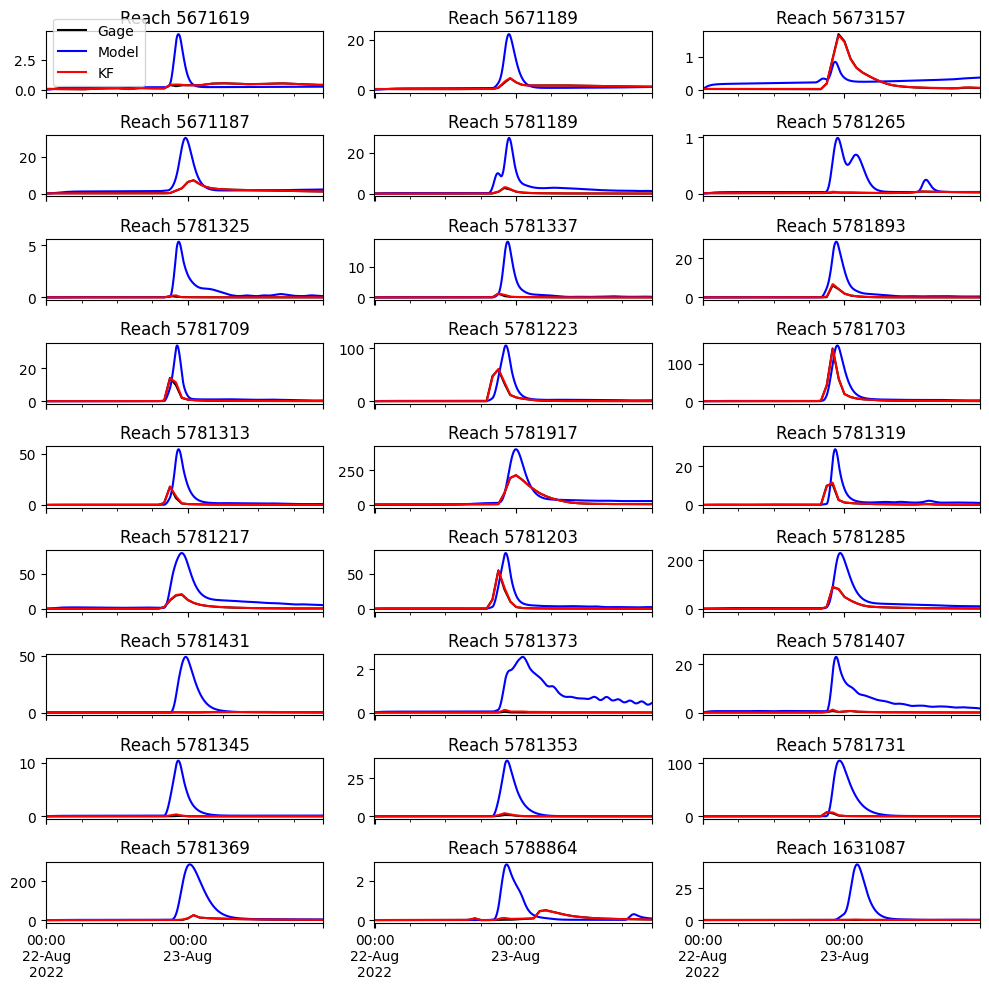

In [12]:
fig, ax = plt.subplots(measurements.columns.size // 3, 3, figsize=(10, 10))

for index, comid in enumerate(measurements.columns):
    measurements[comid].plot(ax=ax.flat[index], c='k', label='Gage')
    outputs_noda[comid].plot(ax=ax.flat[index], c='b', label='Model')
    outputs_da[comid].plot(ax=ax.flat[index], c='r', label='KF')
    if index < measurements.columns.size - 3:
        ax.flat[index].xaxis.set_ticklabels([])
    ax.flat[index].xaxis.set_ticklabels([], minor=True)
    ax.flat[index].set_title(f'Reach {comid}')
ax.flat[0].legend()
plt.tight_layout()


### Plot map of gains

In [13]:
total_gain = (outputs_da - outputs_noda).mean(axis=0)

In [14]:
nwm_streams_tx = gpd.read_file('../data/nwm_streams_tx')
nwm_streams_tx['ID'] = nwm_streams_tx['ID'].astype(int).astype(str)
nwm_streams_travis = nwm_streams_tx[nwm_streams_tx['ID'].isin(input_columns)].copy()
nwm_streams_travis['gain'] = nwm_streams_travis['ID'].map(total_gain).fillna(0.).values
nwm_streams_travis['log_gain'] = np.log(1 + np.abs(nwm_streams_travis['gain'].values))

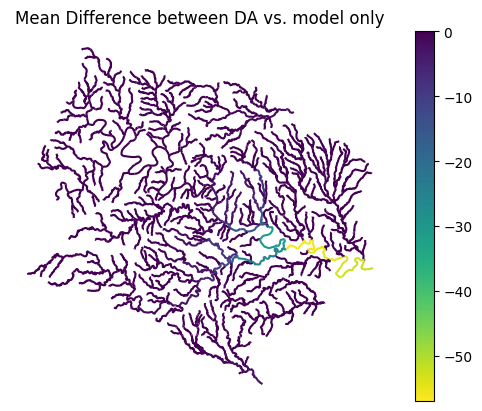

In [15]:
nwm_streams_travis.plot(column='gain', cmap='viridis_r', legend=True)
plt.title('Mean Difference between DA vs. model only')
_ = plt.axis('off')

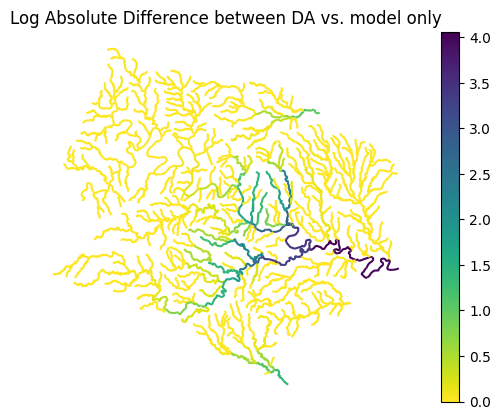

In [16]:
nwm_streams_travis.plot(column='log_gain', cmap='viridis_r', legend=True)
plt.title('Log Absolute Difference between DA vs. model only')
_ = plt.axis('off')